# Fitting for an extended source polarization with `LeakageLib`

This jupyter notebook fits for the polarization of an extended source, with a photon and particle background. Here, the source is a 60 arcsecond-radius uniform disk, though because of the IXPE PSF, it appears wider in the IXPE data.

The source is assumed to have constant polarization, though we provide guidance on variable polarization sources at the end. Spatial, particle, and spectral weights are used.

In [1]:
import numpy as np
import leakagelib
from ixpeobssim.irf import load_arf

>>> PyXSPEC is not installed, you will no be able to use it.


The first step is to load the mock Moments data. We'll center it on pixel (300, 300), and cut to 280 arcseconds around that point. See the point source fit example for a description of these functions.

In [2]:
source = leakagelib.Source.no_image(False)

# Load the extended source data
datas = [leakagelib.IXPEData(source, (
    "data/extended/event_l2/ixpeextended_det1_evt2_v00.fits",
    "data/extended/hk/ixpeextended_det1_att_v00.fits",
), energy_cut=(2,8))]

for data in datas:
    data.explicit_center(300,300)
    data.retain(np.sqrt(data.evt_xs**2 + data.evt_ys**2) < 280)

Now we have to create a custom `Source` object for our extended source: a 60"-radius disk. The source object should not be blurred by the PSF; i.e. it should depict the source as seen by Chandra, not IXPE

In [3]:
pixel_size = 2.9729 # This is the size of the sky PSF pixels; use it for best results
source_pixel_edges = np.arange(0, 280+pixel_size, pixel_size)
source_pixel_edges = np.concatenate([-np.flip(source_pixel_edges)[:-1], source_pixel_edges])
# source_pixel_edges now ranges from -280 to 280, centered on zero, and spaced by `pixel_size`
source_pixel_centers = (source_pixel_edges[1:] + source_pixel_edges[:-1]) / 2

xs, ys = np.meshgrid(source_pixel_centers, source_pixel_centers)
image = (np.sqrt(xs**2 + ys**2) < 60).astype(float)

Now we give the source object to the fitter

In [4]:
source = leakagelib.Source(image, False, len(image), pixel_size)
settings = leakagelib.ps_fit.FitSettings(datas)
settings.add_source(source, "src-ext")
settings.fix_flux("src-ext", 1)

The background and spectral weights are added in the same way as the previous fit, but this time we won't assume zero background polarization.

We are assuming no particles for convenience. This is what you should do if you did not generate particle weights with `leakagelib_bkg`.

In [5]:
settings.add_background("bkg")
settings.set_initial_flux("bkg", 0.1) # Use this function to set the initial value of the background flux

arf = load_arf()
settings.set_spectrum("bkg", lambda e: arf(e) * e**-2.5)
settings.set_spectrum("src-ext", lambda e: arf(e) * e**-1.5)

settings.apply_circular_roi(280)

fitter = leakagelib.Fitter(datas, settings)

>>> Reading (in memory) /opt/homebrew/anaconda3/lib/python3.12/site-packages/ixpeobssim/caldb/ixpe/gpd/cpf/arf/ixpe_d1_obssim20240101_v013.arf...


Let's view what the sources look like:

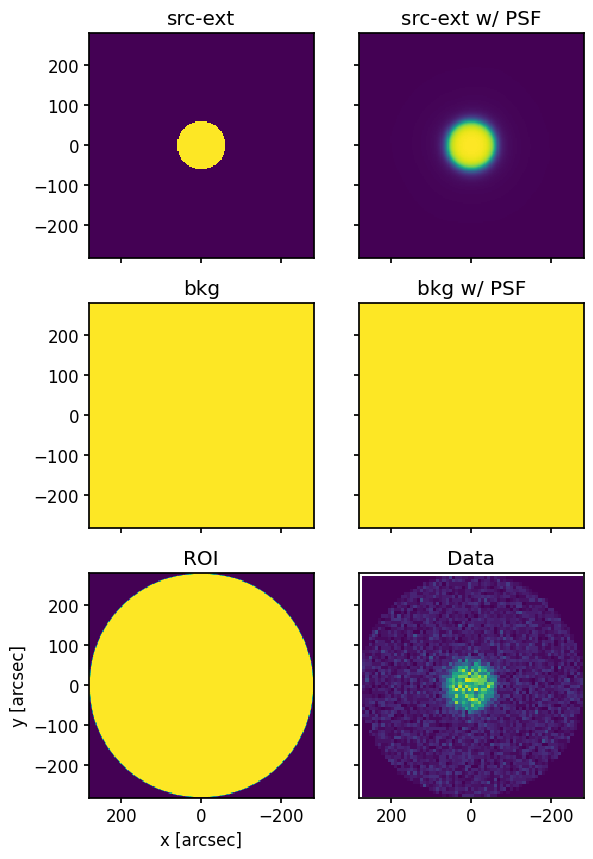

In [6]:
fitter.display_sources(data_pixel_size=8);

It appears that the blurred source does indeed match the data well. Finally, we perform the fit

In [7]:
result = fitter.fit()
result

FitResult:
	q (src-ext) = -0.4023 +/- 0.0000
	u (src-ext) = -0.9155 +/- 0.0000
	q (bkg) = 0.0097 +/- 0.0493
	u (bkg) = -0.0262 +/- 0.0491
	f (bkg) = 0.8858 +/- 0.0125

Polarization:
	PD (src-ext): 1.0000 +/- 0.0000 (50083226.1 sig)
	PA (src-ext): -56.8599 deg +/- 0.0000
	PD (bkg): 0.0280 +/- 0.0492 (0.6 sig)
	PA (bkg): -34.9010 deg +/- 50.4860
Likelihood 10894.327754372436, dof 15609
Optimization terminated successfully.